## 1. Setup models

In [ ]:
# !git clone https://github.com/HemaxiN/DL_ECG_Classification.git

Cloning into 'DL_ECG_Classification'...
remote: Enumerating objects: 811, done.
remote: Counting objects: 100% (259/259), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 811 (delta 162), reused 204 (delta 127), pack-reused 552 (from 1)
Receiving objects: 100% (811/811), 14.00 MiB | 16.55 MiB/s, done.
Resolving deltas: 100% (501/501), done.


In [2]:
!pip install -U -r DL_ECG_Classification/requirements.txt

Defaulting to user installation because normal site-packages is not writeable
  Using cached argon2_cffi-21.3.0-py3-none-any.whl.metadata (5.4 kB)
  Using cached argon2_cffi_bindings-21.2.0-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached asttokens-2.0.5-py2.py3-none-any.whl.metadata (4.6 kB)
  Using cached attrs-21.4.0-py2.py3-none-any.whl.metadata (9.8 kB)
  Using cached certifi-2021.10.8-py2.py3-none-any.whl.metadata (3.0 kB)
  Using cached charset_normalizer-2.0.12-py3-none-any.whl.metadata (11 kB)
  Using cached debugpy-1.6.0-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (1.1 kB)
  Using cached decorator-5.1.1-py3-none-any.whl.metadata (4.0 kB)
  Using cached executing-0.8.3-py2.py3-none-any.whl.metadata (8.6 kB)
  Using cached fonttools-4.31.2-py3-none-any.whl.metadata (121 kB)
  Using cached importlib_resources-5.6.0-py3-none-any.whl.metadata (3.1 kB)
  Using cached ipykernel-6.

In [ ]:
!pip install -q tifffile pyts wfdb torchmetrics torchsummary


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


## 2. Run Dataset.ipynb
* Downloads Challenge-2021, an aggregate dataset
* & performs appropriate Preprocessing

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wfdb
import ast
import pickle
import os
from sklearn.model_selection import train_test_split

In [2]:
def load_raw_data(df, sampling_rate):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

In [3]:
path = 'challenge-2021'
sampling_rate = 100

# load and convert annotation data
Y = pd.read_csv(os.path.join(path, 'records.csv'))
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Shuffle
Y = Y.sample(frac=1).reset_index(drop=True)
X = load_raw_data(Y, sampling_rate)

# Split data into train and test
Y_train, Y_val = train_test_split(Y, test_size=0.2)
Y_dev, Y_test = train_test_split(Y_val, test_size=0.5)

# Load raw signal data
X_train = load_raw_data(Y_train, sampling_rate)
y_train = Y_train.scp_codes
print(f'Train records: {len(y_train)}')

X_dev = load_raw_data(Y_dev, sampling_rate)
y_dev = Y_dev.scp_codes
print(f'Val records: {len(y_dev)}')

X_test = load_raw_data(Y_test, sampling_rate)
y_test = Y_test.scp_codes
print(f'Val records: {len(y_test)}')

Train records: 8021
Val records: 1003
Val records: 1003


In [4]:
# Flatten lists
y_train_flat = pd.Series([', '.join(sublist) for sublist in y_train])
y_dev_flat = pd.Series([', '.join(sublist) for sublist in y_dev])
y_test_flat = pd.Series([', '.join(sublist) for sublist in y_test])

# Get value counts
train_counts = y_train_flat.value_counts()
dev_counts = y_dev_flat.value_counts()
test_counts = y_test_flat.value_counts()

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'y_train': train_counts,
    'y_dev': dev_counts,
    'y_test': test_counts
})

summary_df = summary_df.fillna(0)
summary_df.sort_values(by='y_train', ascending=False)

,y_train,y_dev,y_test
NORM,2260,270.0,265.0
AFIB,2213,259.0,282.0
RBBB,1638,223.0,193.0
1dAVB,839,100.0,115.0
AFLT,330,47.0,48.0
LBBB,279,37.0,39.0
"AFIB, RBBB",247,37.0,33.0
"AFIB, LBBB",77,10.0,9.0
"RBBB, AFLT",40,4.0,6.0
"RBBB, 1dAVB",33,4.0,4.0


In [5]:
preprocessed_dir = 'Processed'
os.makedirs(preprocessed_dir, exist_ok=True)

pickle_out = open(os.path.join(preprocessed_dir, "X.pickle"),"wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "y.pickle"),"wb")
pickle.dump(Y, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "X_train.pickle"),"wb")
pickle.dump(X_train, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "y_train.pickle"),"wb")
pickle.dump(y_train, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "X_dev.pickle"),"wb")
pickle.dump(X_dev, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "y_dev.pickle"),"wb")
pickle.dump(y_dev, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "X_test.pickle"),"wb")
pickle.dump(X_test, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "y_test.pickle"),"wb")
pickle.dump(y_test, pickle_out)
pickle_out.close()

In [6]:
def labelstovector(X, y):
    '''
    Convert the labels in y into vectors:
    Multi-label problem:
    NORM: [0,0,0,0,0]
    AFIB: [1,0,0,0,0]
    AFLT: [0,1,0,0,0]
    1dAVb: [0,0,1,0,0]
    RBBB: [0,0,0,1,0]
    LBBB: [0,0,0,0,1]
    Combination example:
    AFLT and LBBB: [0,1,0,0,1]
    LBBB and RBBB and 1dAVB: [0,0,1,1,1]
    -----------------------------------------------------------
    Args: X (number of examples, signal length, number of leads)
        y (number of examples, )
    '''
    y_list = []
    X_list = []
    for label, ecg in zip(y, X):
        if len(label)!= 0: #ignore examples with label = []
            aux_vec = np.zeros(5)
        if 'AFIB' in label:
            aux_vec[0] = 1
        if 'AFLT' in label:
            aux_vec[1] = 1
        if '1dAVB' in label:
            aux_vec[2] = 1
        if 'RBBB' in label:
            aux_vec[3] = 1
        if 'LBBB' in label:
            aux_vec[4] = 1
    
        y_list.append(aux_vec)
        X_list.append(ecg)
    
    return X_list, y_list

In [7]:
X_train_processed, y_train_processed = labelstovector(X_train, y_train)
X_dev_processed, y_dev_processed = labelstovector(X_dev, y_dev)
X_test_processed, y_test_processed = labelstovector(X_test, y_test)

pickle_out = open(os.path.join(preprocessed_dir, "X_train_processed.pickle"),"wb")
pickle.dump(X_train_processed, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "y_train_processed.pickle"),"wb")
pickle.dump(y_train_processed, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "X_dev_processed.pickle"),"wb")
pickle.dump(X_dev_processed, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "y_dev_processed.pickle"),"wb")
pickle.dump(y_dev_processed, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "X_test_processed.pickle"),"wb")
pickle.dump(X_test_processed, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "y_test_processed.pickle"),"wb")
pickle.dump(y_test_processed, pickle_out)
pickle_out.close()

print('Train size:', X_train.shape)
print('Val size:', X_dev.shape)
print('Test size:', X_test.shape)

Train size: (8021, 1000, 12)
Val size: (1003, 1000, 12)
Test size: (1003, 1000, 12)


In [8]:
# Prepare 2D dataset
!mkdir -p Images/dev/labels
!mkdir -p Images/dev/images
!mkdir -p Images/train/labels
!mkdir -p Images/train/images
!mkdir -p Images/test/labels
!mkdir -p Images/test/images

# Save processed dataset at
!mkdir -p Processed/model_specific/X_rnn_train
!mkdir -p Processed/model_specific/X_rnn_dev
!mkdir -p Processed/model_specific/X_rnn_test
!mkdir -p Processed/model_specific/X_cnn_train
!mkdir -p Processed/model_specific/X_cnn_dev
!mkdir -p Processed/model_specific/X_cnn_test
!mkdir -p Processed/model_specific/labels_train
!mkdir -p Processed/model_specific/labels_dev
!mkdir -p Processed/model_specific/labels_test

# Modify `create_dataset.py` appropriately to
# specify dataset path and save directory path
!python DL_ECG_Classification/Dataset/create_dataset.py

# Error in Train: 747, 2971+747

Processed Processed/model_specific
100%|███████████████████████████████████████| 1003/1003 [09:48<00:00,  1.70it/s]


Model output (5,)
[0. 0. 0. 0. 0.]

1D input: (1000, 3)
[[-0.60007417 -0.37675714 -0.00352023]
 [-0.93490018 -0.6240881  -0.04531275]
 [-0.70611093 -0.49803123 -0.08649083]
 ...
 [-1.66381331 -0.16994399  0.09128046]
 [-1.63355395 -0.02088669  0.00286768]
 [-1.54828664 -0.19507922 -0.01800252]]

2D input: (256, 256)


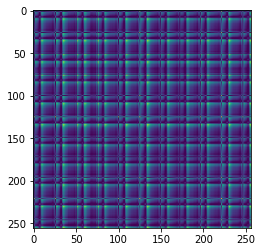

In [9]:
# View label
label = np.load('Processed/model_specific/labels_dev/0.npy')
print('Model output', label.shape)
print(label)

# View RNN input
rnn_input = np.load('Processed/model_specific/X_rnn_dev/0.npy')
print('\n1D input:', rnn_input.shape)
print(rnn_input)

# View CNN input
img = plt.imread('Processed/model_specific/X_cnn_dev/0.tif')
print('\n2D input:', img.shape)
plt.imshow(img)
plt.show()

## 3. Training

In [10]:
%cd DL_ECG_Classification

/home/nepython/projects/COMP6011/Task3/DL_ECG_Classification


### 3.1 1D models

In [11]:
import subprocess
import time

def timed_shell(cmd):
    start = time.time()
    subprocess.run(cmd, shell=True)
    end = time.time()
    print(f'⏱️ Time taken: {end - start:.2f} seconds')

In [13]:
## RNN
timed_shell("python3 rnn.py -data '../Processed/model_specific/' -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01")

Loading data...
Training epoch 1
Training loss: 1.5496
Valid specificity: 0.1736
Valid sensitivity: 0.8408
Training epoch 2
Training loss: 1.5357
Valid specificity: 0.0498
Valid sensitivity: 0.9571
Training epoch 3
Training loss: 1.4984
Valid specificity: 0.0761
Valid sensitivity: 0.9554
Training epoch 4
Training loss: 1.4746
Valid specificity: 0.1274
Valid sensitivity: 0.8993
Training epoch 5
Training loss: 1.4640
Valid specificity: 0.4042
Valid sensitivity: 0.6539
Training epoch 6
Training loss: 1.4581
Valid specificity: 0.2414
Valid sensitivity: 0.8133
Training epoch 7
Training loss: 1.4508
Valid specificity: 0.2289
Valid sensitivity: 0.8237
Training epoch 8
Training loss: 1.4446
Valid specificity: 0.3863
Valid sensitivity: 0.6534
Training epoch 9
Training loss: 1.4433
Valid specificity: 0.0970
Valid sensitivity: 0.9625
Training epoch 10
Training loss: 1.4408
Valid specificity: 0.3881
Valid sensitivity: 0.7609
Training epoch 11
Training loss: 1.4415
Valid specificity: 0.3121
Valid s

In [ ]:
## LSTM
timed_shell("python3 lstm.py -data '../Processed/model_specific/' -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01")

Loading data...
Training epoch 1
Training loss: 1.4131
Training epoch 23
Training loss: 1.4034
eval 929 of 1003

In [43]:
## GRU
timed_shell("python3 gru.py -data '../Processed/model_specific/' -epochs 2 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.005")
# timed_shell("python3 gru_with_attention.py -data '../Processed/model_specific/' -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.05")

Loading data...
Training epoch 1
Training loss: 0.3991
Training epoch 2
Training loss: 0.3412
[[236.  90. 159. 518.   0.]
 [ 42.  12. 379. 570.   0.]
 [ 54.  69. 181. 699.   0.]
 [219.  23.  71. 690.   0.]
 [ 42.  14.  27. 920.   0.]]
       Sensitivity  Specificity  Accuracy  Precision  F1 Score
AFIB          0.24         0.91      0.78       0.40      0.30
AFLT          0.01         0.95      0.76       0.06      0.02
1dAVb         0.18         0.84      0.71       0.22      0.20
RBBB          0.69         0.33      0.40       0.20      0.31
LBBB          0.00         1.00      0.80       0.00      0.00
Mean          0.22         0.81      0.69       0.18      0.17
⏱️ Time taken: 34.02 seconds


### 3.2 2D models

In [ ]:
## AlexNet
timed_shell("python3 AlexNet.py -data '../Processed/model_specific/' -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01")

In [ ]:
## VGGNet
timed_shell("python3 vggnet.py -data '../Processed/model_specific/' -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01")

In [ ]:
## ResNet
timed_shell("python3 resnet.py -data '../Processed/model_specific/' -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01")

In [ ]:
## CNN
timed_shell("python3 cnn.py -data '../Processed/model_specific/' -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01")
timed_shell("python cnn_gru.py -data '../Processed/model_specific/' -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01")
timed_shell("python cnn_lstm.py -data '../Processed/model_specific/' -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01")

### 3.3 Fusion approaches

Fusion uses 1D and 2D models so let's shift it's best models to new folder Models.

In [ ]:
%%bash
#!/bin/bash

# Define the source and destination directories
src_dir="saved_models"
dest_dir="Models"

# Create an associative array to store the largest file for each unique name
declare -A largest_files

# Loop through all files matching the pattern
for file in "$src_dir"/*_ep_*; do
  # Extract the base name (excluding ep_{n})
  base_name=$(basename "$file" | sed 's/_ep_[0-9]*//')
  
  # Check if this base name already has a file stored
  if [[ -z "${largest_files[$base_name]}" ]]; then
    largest_files[$base_name]="$file"
  else
    # Compare the current file with the stored file to find the one with the largest 'n'
    current_n=$(basename "$file" | sed 's/.*_ep_\([0-9]*\).*/\1/')
    stored_n=$(basename "${largest_files[$base_name]}" | sed 's/.*_ep_\([0-9]*\).*/\1/')
    
    if (( current_n > stored_n )); then
      largest_files[$base_name]="$file"
    fi
  fi
done

# Copy the largest files to the new location and rename them
for base_name in "${!largest_files[@]}"; do
  cp "${largest_files[$base_name]}" "$dest_dir/$base_name"
done

In [ ]:
timed_shell("python early_fusion.py -signal_data '../Processed/model_specific/' -image_data '../Processed/model_specific/' -signal_model=gru -image_model=alexnet -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01")

In [ ]:
timed_shell("python late_fusion.py -signal_data '../Processed/model_specific/' -image_data '../Processed/model_specific/' -signal_model=gru -image_model=alexnet -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01")

In [ ]:
timed_shell("python joint_fusion.py -signal_data '../Processed/model_specific/' -image_data '../Processed/model_specific/' -signal_model=gru -image_model=alexnet -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01")

## Evaluation

First, move best models to a separate directory

In [173]:
%%bash
#!/bin/bash

# Define the source and destination directories
src_dir="saved_models"
dest_dir="Models"

# Create an associative array to store the largest file for each unique name
declare -A largest_files

# Loop through all files matching the pattern
for file in "$src_dir"/*_ep_*; do
  # Extract the base name (excluding ep_{n})
  base_name=$(basename "$file" | sed 's/_ep_[0-9]*//')
  
  # Check if this base name already has a file stored
  if [[ -z "${largest_files[$base_name]}" ]]; then
    largest_files[$base_name]="$file"
  else
    # Compare the current file with the stored file to find the one with the largest 'n'
    current_n=$(basename "$file" | sed 's/.*_ep_\([0-9]*\).*/\1/')
    stored_n=$(basename "${largest_files[$base_name]}" | sed 's/.*_ep_\([0-9]*\).*/\1/')
    
    if (( current_n > stored_n )); then
      largest_files[$base_name]="$file"
    fi
  fi
done

# Copy the largest files to the new location and rename them
for base_name in "${!largest_files[@]}"; do
  cp "${largest_files[$base_name]}" "$dest_dir/$base_name"
done

In [52]:
!python eval_saved_models.py -gpu_id 0 \
    -model rnn \
    -path Models/RNN \
    -data ../validation/Processed/model_specific/

/home/nepython/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/nepython/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/nepython/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/nepython/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/nepython/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home

array([1., 0., 0., 0.])